In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from torch.autograd import Variable
from torch.nn import Linear, ReLU, Flatten, Sequential, Conv1d, MaxPool1d, Module, LogSoftmax, NLLLoss, Dropout, MSELoss, Softmax
from torch.optim import Adam, SGD
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch import flatten

In [2]:
activity_encode = {"WALKING":0,
       "WALKING_DOWNSTAIRS":1,
       "WALKING_UPSTAIRS":2,
       "LAYING":3,
       "SITTING":4,
       "STANDING":5
       }

In [3]:
"""
vvv
train_x = np.array(train)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.2)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)
(((5881, 561), (5881,)), ((1471, 561), (1471,)))
^^^

What I did here was basically  split the data after it was loaded, in this case I have to split the data
before we get to this stage
"""
class UCI_Dynamic_Dataset(Dataset):
    """UCI dataset."""

    def __init__(self, csv_file, root_dir, encode=None):

        data = pd.read_csv(csv_file)
        data['Activity'] = data['Activity'].map(encode)
        data, _ = [x for _, x in data.groupby(data['Activity'] > 2)]
        self.data_y = data['Activity'].values
        data = pd.DataFrame(data.drop(['Activity','subject'],axis=1))
        self.data_x = np.array(data)
        self.root_dir = root_dir
        # [batch, channels, features]
        self.data_x = self.data_x.reshape(len(self.data_x), 1, 561)
        self.data_x  = torch.from_numpy(self.data_x)
        self.data_y = self.data_y.astype(int)
        self.data_y = torch.from_numpy(self.data_y)

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        return self.data_x[idx], self.data_y[idx]

In [4]:
train_data = UCI_Dynamic_Dataset(csv_file='train.csv', root_dir='',encode=activity_encode)
valid_data = UCI_Dynamic_Dataset(csv_file='valid.csv', root_dir='',encode=activity_encode)
test_data = UCI_Dynamic_Dataset(csv_file='test.csv', root_dir='',encode=activity_encode)


In [5]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [6]:
class DynamicCNN(Module):
    def __init__(self):
        super(DynamicCNN, self).__init__()

        self.conv1 = Conv1d(1, 100, kernel_size=tuple([3]))
        self.pool =  MaxPool1d(kernel_size=tuple([3]))
        self.fc = Linear(18600, 3)
        self.dropout = Dropout(0.5)

    # Defining the forward pass
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #[32, 100, 186]
        x = x.view(-1, 1 * 100 * 186)
        x = self.dropout(F.softmax(self.fc(x), dim=1))
        return x

In [11]:
#NLLL not MSE because
criterion = NLLLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DynamicCNN()
epochs = 100

step = 10
optimizer = Adam(model.parameters(), lr=0.0005)
model.to(device)

losses = []
for i in range(epochs):
    loss= 0
    for j,(x_train, y_train) in enumerate(trainloader):
        #get the prediction
        x_train, y_train = x_train.to(device).float(), y_train.to(device).long()
        y_pred = model(x_train)

        #losses
        loss = criterion(y_pred, y_train)
        losses.append(loss)    #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  #print loss

    if i % 10 == 0:
        print("epoch : {} loss: {}".format(i,loss))

epoch : 0 loss: -0.125
epoch : 10 loss: -0.5
epoch : 20 loss: -0.125
epoch : 30 loss: -4.2146275358589946e-10
epoch : 40 loss: -0.5
epoch : 50 loss: -0.5
epoch : 60 loss: -0.625
epoch : 70 loss: -0.25
epoch : 80 loss: -2.6341401282437005e-10
epoch : 90 loss: -0.375


Text(0, 0.5, 'loss')

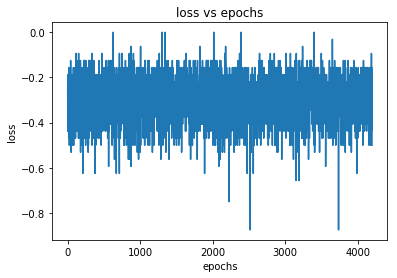

In [12]:
plt.plot(losses)
plt.title('loss vs epochs')
plt.xlabel('epochs')
plt.ylabel('loss')

In [ ]:
correct = 0
total = 0
model.to(device)
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device).float(), labels.to(device).long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test set: %d %%' % (
    100 * correct / total))


